# Linear transformations
In this module we'll work with linear and affine transformations.

We will show how to apply them to point sets, 

In [91]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os # for os.path.join to work with windows and mac/linux

## Let's start by writing some functions for loading data

In [92]:
# get a landmarks
fname = os.path.join('hipAmygLandmarks','hippocampus_01_landmarks.txt')
def load_landmarks(fname):
    '''Load landmarks from text file, we assume that the first line has size info'''
    with open(fname) as f:
        for i,line in enumerate(f):
            if i == 0:
                # the first line says the size of the file
                d,n = [int(n) for n in line.split()]
                X = np.empty((d,n))
                continue
            X[:,i-1] = [float(n) for n in line.split()]
    return X
X = load_landmarks(fname)

In [93]:
# a surface
fname = os.path.join('hipAmygLandmarks','hippocampus_01_surface.byu')
def load_surface(fname):
    '''Load byu surface from text file'''
    with open(fname) as f:
        for i,line in enumerate(f):
            if i == 0:
                # the first gives info about file
                _,nv,nf,_ = [int(n) for n in line.split()]
                vertices = np.empty((3,nv),dtype=float)
                faces = np.empty((nf,3),dtype=int)
                continue
            elif i == 1:
                continue
            if i <= nv+1:
                vertices[:,i-2] = [float(n) for n in line.split()]
            else:
                faces[i-(nv+2),:] = [np.abs(int(n))-1 for n in line.split()]
    return vertices,faces
vertices,faces = load_surface(fname)

In [96]:
def axis_equal(ax=None):
    '''Set x,y,z axes to constant aspect ratio'''
    if ax is None: ax=plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    cx = np.mean(xlim)
    cy = np.mean(ylim)
    cz = np.mean(zlim)
    rx = np.diff(xlim)
    ry = np.diff(ylim)
    rz = np.diff(zlim)
    r = np.max([rx,ry,rz])
    ax.set_xlim(cx + np.array([-1,1])*0.5*r)
    ax.set_ylim(cy + np.array([-1,1])*0.5*r)
    ax.set_zlim(cz + np.array([-1,1])*0.5*r)

<IPython.core.display.Javascript object>


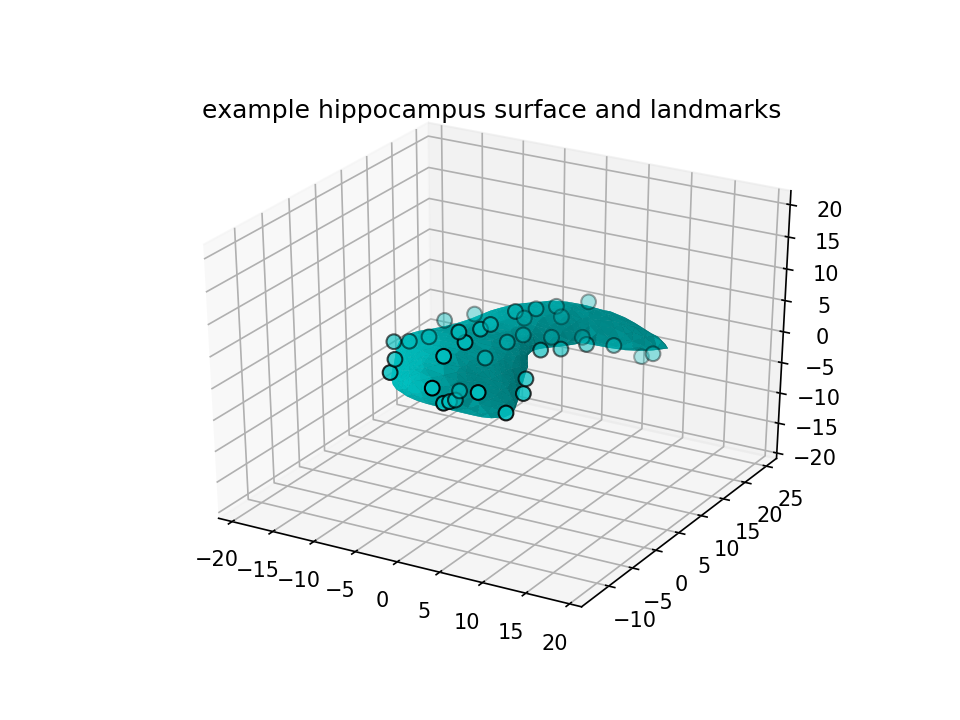

Text(0.5,0.92,'example hippocampus surface and landmarks')

In [95]:
# 
f = plt.figure()
ax = f.add_subplot(111,projection='3d')
color = 'c'
hp = ax.scatter(X[0,:],X[1,:],X[2,:],s=50,c=color,edgecolor='k')
hs = ax.plot_trisurf(vertices[0,:],vertices[1,:],vertices[2,:],triangles=faces,
                    edgecolor='none',linewidth=0,color=color)
axis_equal(ax)
ax.set_title('example hippocampus surface and landmarks')


<IPython.core.display.Javascript object>


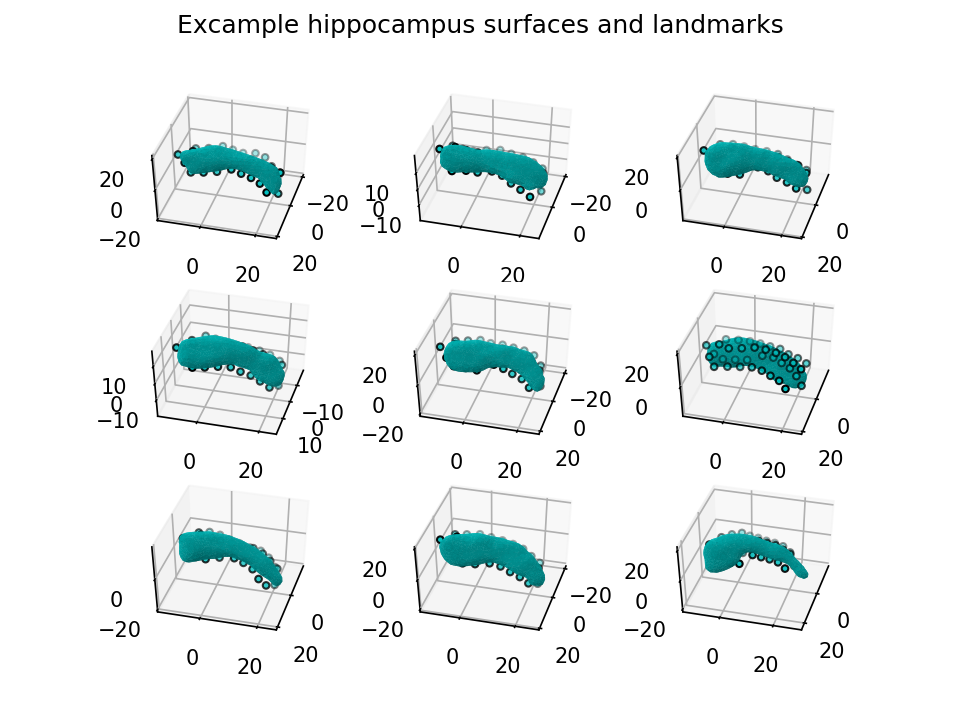

Text(0.5,0.98,'Excample hippocampus surfaces and landmarks')

In [183]:

f = plt.figure()
nshow = 9
nrow = np.ceil(np.sqrt(nshow))
ncol = nrow
for i in range(nshow):
    fname = os.path.join('hipAmygLandmarks','hippocampus_{:02d}_surface.byu'.format(i+1))
    vertices,faces = load_surface(fname)
    fname = os.path.join('hipAmygLandmarks','hippocampus_{:02d}_landmarks.txt'.format(i+1))
    X = load_landmarks(fname)
    ax = f.add_subplot(nrow,ncol,i+1,projection='3d')
    color = 'c'
    hp = ax.scatter(X[0,:],X[1,:],X[2,:],s=10,c=color,edgecolor='k')
    hs = ax.plot_trisurf(vertices[0,:],vertices[1,:],vertices[2,:],triangles=faces,
                        edgecolor='none',linewidth=0,color=color)
    ax.view_init(45,15)
    axis_equal(ax)
    
    # save a couple for later use
    if i == 0:
        vertices0 = vertices
        faces0 = faces
        X0 = X
    elif i == 1:
        vertices1 = vertices
        faces1 = faces
        X1 = X
f.suptitle('Excample hippocampus surfaces and landmarks')

## Applying transformations
Here we will apply some randomly generated transformations to our hippocampus

<IPython.core.display.Javascript object>


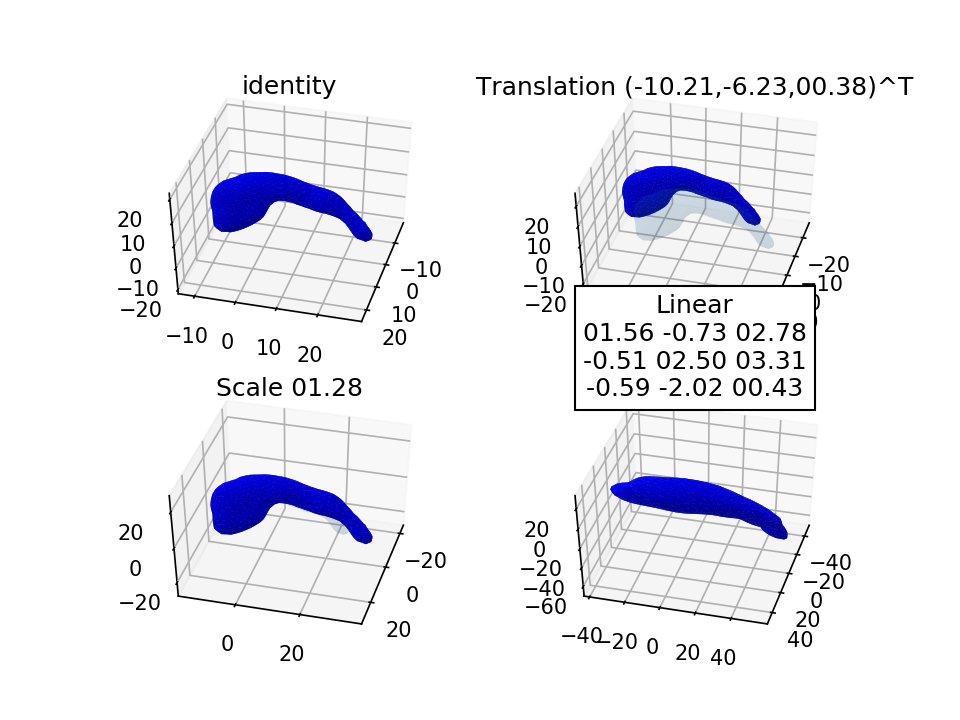

Text(0.5,0.92,'Linear\n01.56 -0.73 02.78\n-0.51 02.50 03.31\n-0.59 -2.02 00.43')

In [180]:
# homogeneous coords
verticesh = np.concatenate([vertices,np.ones((1,vertices.shape[1]))])
f = plt.figure()

# first identity
ax = f.add_subplot(221,projection='3d')
ax.plot_trisurf(vertices[0,:],vertices[1,:],vertices[2,:],triangles=faces,alpha=0.1)
ax.view_init(45,15)
# homogeneous transformation matrix
A = np.eye(4)
Averticesh = A.dot(verticesh)
ax.plot_trisurf(Averticesh[0,:],Averticesh[1,:],Averticesh[2,:],triangles=faces,color='b')
axis_equal(ax)
ax.set_title('identity')

# now translation
ax = f.add_subplot(222,projection='3d')
ax.plot_trisurf(vertices[0,:],vertices[1,:],vertices[2,:],triangles=faces,alpha=0.1)
ax.view_init(45,15)
# homogeneous transformation matrix
A = np.eye(4)
A[:3,-1] += np.random.randn(3)*10.0
Averticesh = A.dot(verticesh)
ax.plot_trisurf(Averticesh[0,:],Averticesh[1,:],Averticesh[2,:],triangles=faces,color='b')
axis_equal(ax)
ax.set_title('Translation ({:-05.2f},{:-05.2f},{:-05.2f})^T'.format(*list(A[:3,-1])))


# now scale
ax = f.add_subplot(223,projection='3d')
ax.plot_trisurf(vertices[0,:],vertices[1,:],vertices[2,:],triangles=faces,alpha=0.1)
ax.view_init(45,15)
A = np.eye(4)*(1.0 + np.random.randn())
Averticesh = A.dot(verticesh)
ax.plot_trisurf(Averticesh[0,:],Averticesh[1,:],Averticesh[2,:],triangles=faces,color='b')
axis_equal(ax)
ax.set_title('Scale {:-05.2f}'.format(A[0,0]))


# now linear
ax = f.add_subplot(224,projection='3d')
ax.plot_trisurf(vertices[0,:],vertices[1,:],vertices[2,:],triangles=faces,alpha=0.1)
ax.view_init(45,15)
A = np.eye(4)
A[:3,:3] += np.random.randn(3,3)*1.5
Averticesh = A.dot(verticesh)
ax.plot_trisurf(Averticesh[0,:],Averticesh[1,:],Averticesh[2,:],triangles=faces,color='b')
axis_equal(ax)
ax.set_title('''Linear
{:-05.2f} {:-05.2f} {:-05.2f}
{:-05.2f} {:-05.2f} {:-05.2f}
{:-05.2f} {:-05.2f} {:-05.2f}'''.format(A[0,0],A[0,1],A[0,2],A[1,0],A[1,1],A[1,2],A[2,0],A[2,1],A[2,2]),bbox={'fc':'w','ec':'k'})


## Estimating transformations

Generally given a set of labeled points $X$ and $Y$ we will want to estimate an optimal transformation that brings $AX$ close to $Y$.  This is typically done by minimizing sum of square error.  


### Translations
For example for translation $T$ we can define a cost function $E$ as
\begin{align}
E = \sum_{i = 1}^N \frac12|(X_i + T) - Y_i|^2
\end{align}
where $|\cdot|^2$ denotes the norm squared of each point.

We'd like to minimize this over translations.  Let's take the derivative and set it to zero.

\begin{align}
\nabla E &= \sum_{i = 1}^N 2(X_i + T - Y_i)
\end{align}
Setting to zero and rearranging gives
\begin{align}
T = \frac{1}{N}\sum_{i = 1}^N Y_i - X_i
\end{align}
In other words, the optimal translation is to subtract the mean of $X$ and add the mean of $Y$.



[-1.00958782 -0.85311863 -0.58005905]


<IPython.core.display.Javascript object>


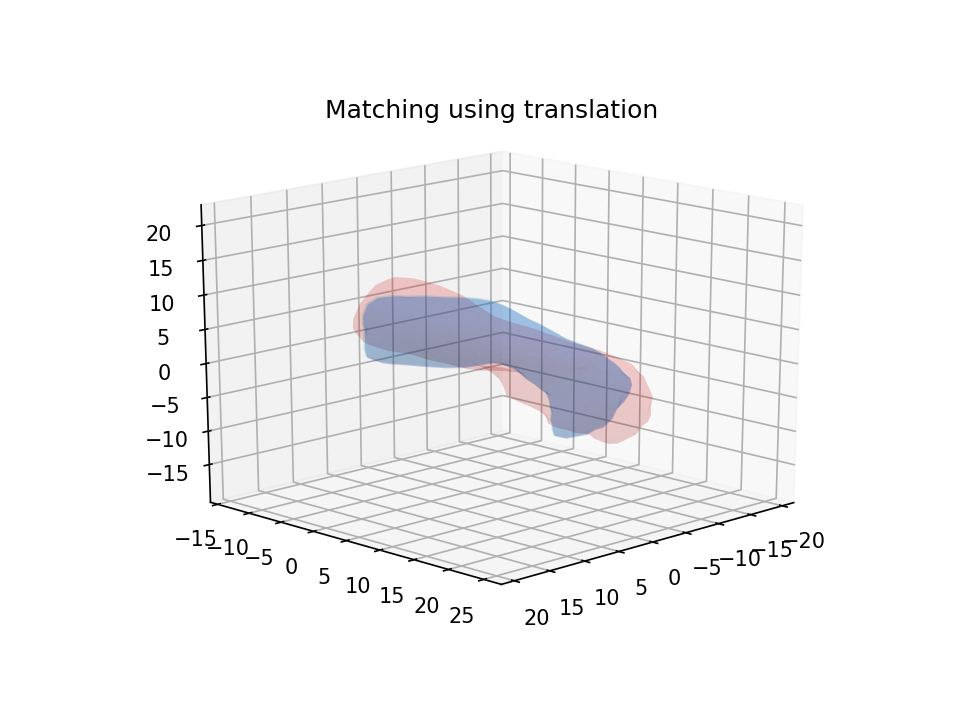

Text(0.5,0.92,'Matching using translation')

In [193]:
# Example: match X0 to X1 using translation
T = np.mean(X1,axis=1) - np.mean(X0,axis=1)
AX0 = X0 + T[:,None]
Avertices0 = vertices0 + T[:,None]
print(T)

f = plt.figure()
ax = f.add_subplot(111,projection='3d')
ax.plot_trisurf(vertices0[0,:],vertices0[1,:],vertices0[2,:],triangles=faces0,alpha=0.1,color='c')
ax.plot_trisurf(vertices1[0,:],vertices1[1,:],vertices1[2,:],triangles=faces1,alpha=0.1,color='r')
ax.plot_trisurf(Avertices0[0,:],Avertices0[1,:],Avertices0[2,:],triangles=faces0,alpha=0.1,color='b')
ax.view_init(45,15)
axis_equal(ax)
ax.set_title('Matching using translation')

### Scaling
Define a cost function $E$ as
\begin{align}
E = \sum_{i = 1}^N \frac12 |s X_i - Y_i|^2
\end{align}

Take the gradient
\begin{align}
\nabla E = \sum_{i = 1}^N 2(s X_i - Y_i) \cdot X_i
\end{align}

Set to zero and rearrange
\begin{align}
s = \frac{\frac1N\sum_{i = 1}^N Y_i \cdot X_i }{ \frac1N\sum_{i = 1}^N X_i \cdot X_i }
\end{align}

Note this pattern of "covariance over variance".  We will see this again.

0.9452631243680863


<IPython.core.display.Javascript object>


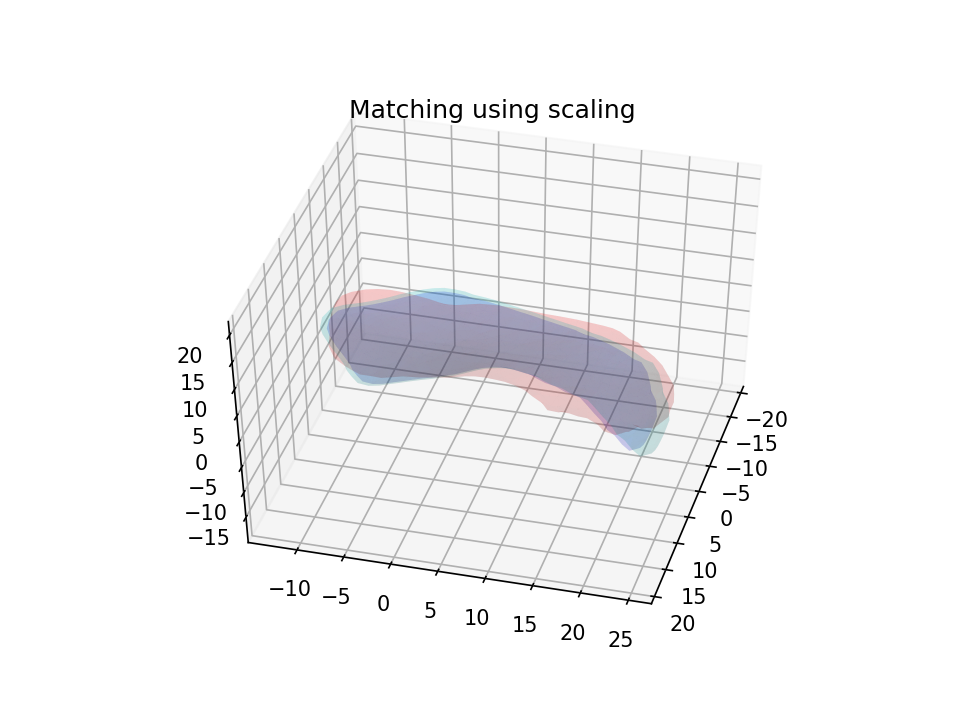

Text(0.5,0.92,'Matching using scaling')

In [195]:
# Example: match X0 to X1 using scaling
s = np.sum(X0*X1)/np.sum(X0*X0)
AX0 = s*X0
Avertices0 = s*vertices0
print(s)

f = plt.figure()
ax = f.add_subplot(111,projection='3d')
ax.plot_trisurf(vertices0[0,:],vertices0[1,:],vertices0[2,:],triangles=faces0,alpha=0.1,color='c')
ax.plot_trisurf(vertices1[0,:],vertices1[1,:],vertices1[2,:],triangles=faces1,alpha=0.1,color='r')
ax.plot_trisurf(Avertices0[0,:],Avertices0[1,:],Avertices0[2,:],triangles=faces0,alpha=0.1,color='b')
ax.view_init(45,15)
axis_equal(ax)
ax.set_title('Matching using scaling')

### Linear or affine
Define a cost function $E$ as
\begin{align}
E = \sum_{i = 1}^N \frac12 |A X_i - Y_i|^2
\end{align}
If $A$ and $X,Y$ are in homogeneous coordinates, then this corresponds to an affine transformation.  Otherwise a linear transformation.

We'd like to take the derivative and set to zero.  You may not know how to do this for a matrix.  Let's use a standard approach.  We'll take the directional derivative in the direction of $\delta A$, and make sure the solution is stationary for all directions.

First we'll rewrite the norm as a trace
\begin{align}
E &= \sum_{i = 1}^N \frac12 |A X_i - Y_i|^2\\
&= \sum_{i = 1}^N \frac12 (A X_i - Y_i)^T(A X_i - Y)\\
&= \sum_{i = 1}^N \frac12 \text{trace}[(A X_i - Y_i)(A X_i - Y)^T]\\
\end{align}

Now 
\begin{align}
&\frac{d}{d\epsilon} E(A + \epsilon \delta A)\bigg|_{\epsilon = 0} \\
&=\frac{d}{d\epsilon} \sum_{i = 1}^N \frac12 \text{trace}[(A X_i + \epsilon \delta A X_i- Y_i)(A X_i + \epsilon \delta A X_i- Y)^T] \bigg|_{\epsilon = 0}\\
&= \sum_{i = 1}^N \frac12 \text{trace}[(AX_i - Y_i)(\delta A X_i)^T + (\delta A X_i)(A X_i - Y_i)^T] \\
&= \sum_{i = 1}^N \text{trace}[(AX_i - Y_i)(\delta A X_i)^T ] \\
&= \sum_{i = 1}^N \text{trace}[[(AX_i - Y_i) X_i^T] \delta A^T ] \\
\end{align}
We used the fact that the trace is invariant to the transpose.

Now if this quantity is to vanish for all perturbations, we must have
\begin{align}
\sum_{i = 1}^N (AX_i - Y_i) X_i^T = 0
\end{align}
Rearranging and solving for $A$ gives
\begin{align}
A = \left( \frac{1}{N}\sum_{i = 1}^N Y_i X_i^T \right)\left(\frac{1}{N}\sum_{i = 1}^N X_i X_i^T\right)^{-1}
\end{align}
Again we see that the result takes the form of an inverse covariance, times a cross covariance.  This is a typical result in linear signal estimation.

[[ 1038.26617973  -958.41256481   -80.91333948   -56.858961  ]
 [  -23.51644091  5648.33689051  -480.1190529    220.755786  ]
 [  -36.89704402 -1336.47725282   526.22189298    22.440575  ]
 [  -18.494624     253.174294      44.482819      38.        ]]
[[1043.76691952 -202.56756023 -114.49100344  -18.494624  ]
 [-202.56756023 6132.89717524 -508.97731635  253.174294  ]
 [-114.49100344 -508.97731635  453.83029063   44.482819  ]
 [ -18.494624    253.174294     44.482819     38.        ]]
[[ 9.61372919e-01 -1.24715234e-01 -6.35649805e-02 -1.23065512e-01]
 [ 1.68033350e-01  9.68200432e-01  1.41374003e-01 -7.24965141e-01]
 [ 4.47225761e-02 -1.66657424e-01  9.20673591e-01  6.44918977e-01]
 [ 3.46944695e-18 -1.99493200e-17 -5.55111512e-17  1.00000000e+00]]
0.9452631243680863


<IPython.core.display.Javascript object>


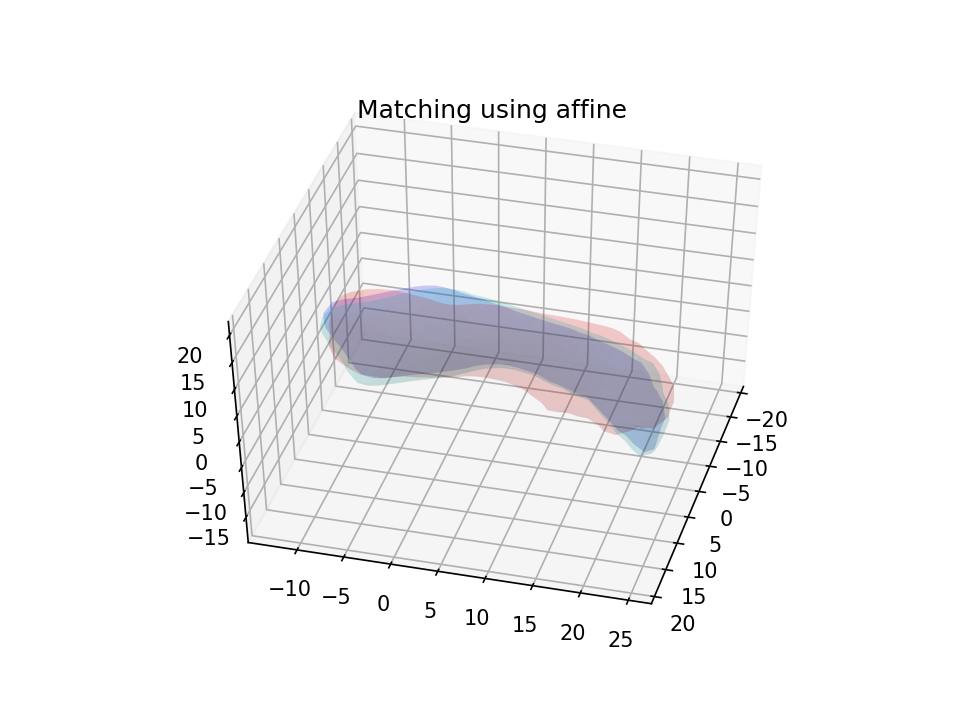

Text(0.5,0.92,'Matching using affine')

In [210]:
# Example: match X0 to X1 using affine
X0h = np.concatenate([X0,np.ones((1,X0.shape[1]))],axis=0)
X1h = np.concatenate([X1,np.ones((1,X0.shape[1]))],axis=0)
vertices0h = np.concatenate([vertices0,np.ones((1,vertices0.shape[1]))],axis=0)

xcov = X1h.dot(X0h.transpose())
cov = X0h.dot(X0h.transpose())
print(xcov)
print(cov)
A =xcov.dot( np.linalg.inv(cov))
print(A)
AX0 = A.dot(X0h)
Avertices0 = A[:3,:].dot(vertices0h)
print(s)

f = plt.figure()
ax = f.add_subplot(111,projection='3d')
ax.plot_trisurf(vertices0[0,:],vertices0[1,:],vertices0[2,:],triangles=faces0,alpha=0.1,color='c')
ax.plot_trisurf(vertices1[0,:],vertices1[1,:],vertices1[2,:],triangles=faces1,alpha=0.1,color='r')
ax.plot_trisurf(Avertices0[0,:],Avertices0[1,:],Avertices0[2,:],triangles=faces0,alpha=0.1,color='b')
ax.view_init(45,15)
axis_equal(ax)
ax.set_title('Matching using affine')

### Bonus: Rotations
Because rotation matrices do not lie in a vector space (if you add and subtract them you will not generally get another rotation), we have to use different methods for solving this problem.

Write the cost
\begin{align}
E &= \sum_{i = 1}^N \frac12 |R X_i - Y_i|^2
\end{align}

Lets put all our data into one big matrix and use the Frobeneous norm
\begin{align}
E &= \frac12 \|R X - Y\|^2_F
\end{align}

Now we'll use our trace trick as before
\begin{align}
E &= \frac12 \text{trace}(RX - Y)(RX - Y)^T
\end{align}
The constant term $YY^T$ does not affect our minimizer, so let's drop it
\begin{align}
&\simeq \frac12 \text{trace}(RX - Y)(RX) ^T\\
&= \frac12 \text{trace}(RX - Y)X^TR^T\\
&= \frac12 \text{trace}R^T(RX - Y)X^T\\
&= \frac12 \text{trace}(X - R^TY)X^T\\
\end{align}
The constant term $XX^T$ doesn't affect our minimizer, so let's drop it
\begin{align}
&\simeq -\frac12 \text{trace} R^TYX^T\\
\end{align}
The idea is that this looks like an inner product, and it can be minimized when $R$ is "parallel" to $YX^T$
Let the matrix $YX^T = M$, note that it is 3x3
\begin{align}
&=-\frac12 \text{trace} R^TM\\
\end{align}
Write the singular value decomposition  $M = UDV^T$
\begin{align}
&=-\frac12 \text{trace} R^T UDV^T \\
&=-\frac12 \text{trace} V^TR^T U D \\
\end{align}
Now this can be minimized when $V^T R^T U$ is a diagonal matrix with diagonal entries (which of course have magnitude 1) pointing in the same direction as $D$.  In other words
\begin{align}
V^T R^T U = \text{sign}(D)
\end{align}
Which we can easily solve as
\begin{align}
R =  U^T \text{sign}(D) V
\end{align}